In [88]:
import math
import copy
import numpy as np
import scipy
import pandas as pd
import anndata
import scanpy as sc
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn.decomposition
import matplotlib.pyplot as plt

In [2]:
ad = anndata.AnnData(
    X = scipy.io.mmread('/home/anders/sds/sd17l002/u/anders/ifnagrko/ifnagrko_raw_counts.mtx.gz').tocsr(),
    obs = pd.read_csv('/home/anders/sds/sd17l002/u/anders/ifnagrko/ifnagrko_obs.csv.gz'),
    var = pd.read_csv('/home/anders/sds/sd17l002/u/anders/ifnagrko/ifnagrko_var.csv') )

/home/anders/pyenv_torch/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/anders/pyenv_torch/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [3]:
ad.layers["counts"] = ad.X.copy()
sc.pp.normalize_total( ad )
sc.pp.highly_variable_genes(
    ad,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    subset=True,
)
ad

AnnData object with n_obs × n_vars = 18302 × 2000
    obs: 'barcode', 'celltype', 'celltype1', 'celltype2', 'dpt_pseudotime', 'svz_frac', 'hto_sum', 'leiden', 'dbscan', 'frac_mito', 'counts', 'genes', 'scrub_score', 'age', 'genotype', 'UMAP1', 'UMAP2'
    var: 'Unnamed: 0', 'gene_name', 'gene_id', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'
    layers: 'counts'

In [6]:
counts = torch.tensor( ad.layers["counts"].todense(), dtype=torch.float32 )
totals = counts.sum(1)
lncounts = torch.log( counts/totals[:,None] + 1e-4 )

In [9]:
pca = sklearn.decomposition.PCA(20).fit( lncounts.numpy() )
pca.components_.shape

(20, 2000)

In [34]:
encoder_centers = lncounts.mean(0).clone().requires_grad_(True)
encoder_matrix = torch.tensor( pca.components_.T, requires_grad=True, dtype=torch.float32 )
decoder_matrix = torch.tensor( pca.components_, requires_grad=True, dtype=torch.float32 )
decoder_centers = lncounts.mean(0).clone().requires_grad_(True)

In [11]:
latent = ( lncounts - encoder_centers ) @ encoder_matrix
latent

tensor([[ 1.1630e+01,  2.7517e+01,  2.3102e+00,  ...,  9.2211e-01,
         -1.2445e+00, -5.8396e-01],
        [-2.1500e+01, -4.7937e+00, -1.7415e+00,  ...,  1.4030e+00,
         -1.4130e+00, -2.9863e+00],
        [ 2.3597e+01, -8.0399e+00, -1.2087e-01,  ...,  2.4568e+00,
          8.8939e-01,  4.5007e+00],
        ...,
        [-1.3697e+01, -1.7856e+00,  1.7581e+01,  ...,  2.4613e+00,
          3.8042e-01, -9.2547e-01],
        [-1.5142e+00,  9.7162e+00, -5.6973e+00,  ..., -2.0212e+00,
          2.5672e-02, -6.3906e-01],
        [-1.4272e+01, -3.9927e+00,  2.3455e+01,  ...,  1.0099e+00,
          2.9713e-01, -2.1273e+00]], grad_fn=<MmBackward0>)

In [12]:
lambda_hat = torch.exp( latent @ decoder_matrix + decoder_centers ) * totals[:,None]

In [13]:
lambda_hat

tensor([[2.5049e-01, 2.0214e-01, 4.7346e-01,  ..., 5.2245e+01, 2.4171e-01,
         2.3430e-01],
        [9.0665e-02, 2.3785e-01, 1.3015e-01,  ..., 5.7705e+01, 9.3463e-02,
         1.4912e+00],
        [1.5239e-01, 1.5394e-01, 2.1735e+00,  ..., 8.6692e-01, 1.5844e-01,
         3.3152e-01],
        ...,
        [1.5659e-01, 2.0947e-01, 1.1862e-01,  ..., 1.6465e+02, 1.5789e-01,
         7.7177e+00],
        [3.8133e-02, 3.7210e-02, 5.0348e-02,  ..., 4.0214e+00, 9.5131e-02,
         5.5177e-02],
        [1.5728e-01, 2.2616e-01, 1.6303e-01,  ..., 9.0928e+01, 1.7404e-01,
         6.9949e+00]], grad_fn=<MulBackward0>)

In [14]:
counts

tensor([[  0.,   0.,   0.,  ...,  46.,   0.,   0.],
        [  0.,   0.,   0.,  ...,  90.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,  ..., 109.,   0.,  12.],
        [  0.,   0.,   0.,  ...,  21.,   0.,   0.],
        [  0.,   0.,   0.,  ..., 151.,   0.,   9.]])

In [15]:
alpha = .2**2

In [16]:
nbprob = 1. / ( lambda_hat * alpha + 1. )

In [17]:
log_likelihood = torch.lgamma( counts + 1./alpha ) - math.lgamma(1./alpha) - torch.lgamma( counts + 1 ) + counts * torch.log( 1 - nbprob ) + (1./alpha) * torch.log( nbprob )
log_likelihood.sum()

tensor(-16732323., grad_fn=<SumBackward0>)

In [18]:
log_likelihood = torch.lgamma( counts + 1./alpha ) - math.lgamma(1./alpha) - torch.lgamma( counts + 1 ) + \
    torch.xlogy( counts, 1 - nbprob ) + torch.xlogy( 1./alpha, nbprob )
log_likelihood.sum()

tensor(-16732323., grad_fn=<SumBackward0>)

In [19]:
nbprob0 = 1. / ( counts * alpha + 1 )
log_likelihood_saturated = torch.lgamma( counts + 1./alpha ) - math.lgamma(1./alpha) - torch.lgamma( counts + 1 ) + \
    torch.xlogy( counts, 1 - nbprob0 ) + torch.xlogy( 1./alpha, nbprob0 )
( -2 * (log_likelihood - log_likelihood_saturated ) ).mean().item()


0.5815576314926147

In [20]:
log_likelihood_part = counts * torch.log( 1 - nbprob ) + (1./alpha) * torch.log( nbprob )
loss = -log_likelihood_part.sum()
loss

tensor(54075896., grad_fn=<NegBackward0>)

In [21]:
loss.backward()

In [22]:
encoder_centers.grad

tensor([-939.5082, 1316.0903, 3787.9824,  ..., 7095.9502, -346.8978,
        6605.7959])

In [23]:
decoder_matrix

tensor([[-4.3974e-06, -1.1479e-02,  5.7341e-02,  ..., -8.9799e-02,
          9.9221e-04, -6.2656e-02],
        [ 1.4553e-03, -4.5472e-03, -4.3717e-02,  ...,  1.2532e-02,
          1.1846e-03, -3.7184e-02],
        [-3.7185e-04,  1.1363e-02, -3.1827e-03,  ...,  3.8812e-02,
         -6.9147e-04,  6.2706e-02],
        ...,
        [-4.8306e-03,  1.8585e-02,  1.8708e-02,  ..., -5.7901e-02,
         -7.0025e-04,  1.8238e-02],
        [ 4.0338e-04,  3.7371e-02,  1.3643e-02,  ...,  3.1685e-03,
         -5.1020e-04,  1.1436e-02],
        [-4.9728e-04,  1.7212e-03, -3.5354e-02,  ...,  2.1039e-02,
         -7.3830e-04,  1.2716e-01]], requires_grad=True)

In [24]:
decoder_matrix.grad

tensor([[ 1.0705e+04,  4.9684e+04, -1.3327e+05,  ...,  1.1444e+04,
          8.1080e+03,  2.1411e+05],
        [ 3.1664e+03,  9.8356e+03,  3.3381e+04,  ..., -5.4091e+03,
          3.1639e+03,  4.1589e+04],
        [ 6.3209e+03, -4.2251e+03,  6.2486e+03,  ..., -4.0955e+04,
          6.6417e+03, -6.2264e+04],
        ...,
        [ 1.7448e+02, -1.0185e+03, -5.9606e+02,  ..., -5.5355e+03,
          3.9751e+01, -2.3006e+03],
        [-9.8762e+01, -1.7503e+03, -1.7647e+03,  ..., -5.6964e+03,
         -6.9122e+01, -2.0445e+02],
        [ 1.9211e+01,  2.7887e+02,  1.7133e+03,  ...,  7.1400e+03,
          6.0949e+01, -4.7210e+03]])

In [25]:
with torch.no_grad():
    encoder_centers -= 1e-8 * encoder_centers.grad
    encoder_matrix  -= 1e-8 * encoder_matrix.grad
    decoder_matrix  -= 1e-8 * decoder_matrix.grad    
    decoder_centers -= 1e-8 * decoder_centers.grad

In [26]:
latent = ( lncounts - encoder_centers ) @ encoder_matrix
lambda_hat = torch.exp( latent @ decoder_matrix + decoder_centers ) * totals[:,None]

In [27]:
nbprob = 1. / ( lambda_hat * alpha + 1 )
log_likelihood_part = counts * torch.log( 1 - nbprob ) + (1./alpha) * torch.log( nbprob )
loss = -log_likelihood_part.sum()
loss

tensor(53987828., grad_fn=<NegBackward0>)

In [28]:
optimizer = torch.optim.Adam( ( encoder_centers, encoder_matrix, decoder_matrix, decoder_centers ), lr=1e-8 )

[tensor([-9.1620, -9.0162, -8.1960,  ..., -4.8811, -9.1269, -7.6952],
        device='cuda:0'),
 tensor([[-0.0229, -0.0136, -0.0276,  ...,  0.0174,  0.0304, -0.0231],
         [-0.0061,  0.0132,  0.0337,  ...,  0.0030,  0.0129,  0.0197],
         [ 0.0642, -0.0506, -0.0197,  ...,  0.0146,  0.0099, -0.0345],
         ...,
         [-0.1027,  0.0014,  0.0586,  ..., -0.0757,  0.0235,  0.0279],
         [-0.0119, -0.0004, -0.0293,  ...,  0.0207,  0.0335, -0.0244],
         [-0.0655, -0.0440,  0.0801,  ...,  0.0246,  0.0319,  0.1345]],
        device='cuda:0'),
 tensor([[-0.0149, -0.0324,  0.0714,  ..., -0.0739, -0.0046, -0.0775],
         [-0.0159, -0.0234, -0.0434,  ...,  0.0194, -0.0099, -0.0539],
         [-0.0206,  0.0141, -0.0156,  ...,  0.0416, -0.0178,  0.0615],
         ...,
         [ 0.0117,  0.0413,  0.0080,  ..., -0.0390,  0.0284,  0.0251],
         [ 0.0287,  0.0625,  0.0155,  ...,  0.0161,  0.0276,  0.0330],
         [-0.0288, -0.0220, -0.0378,  ...,  0.0116, -0.0286,  0.1216

In [154]:
encoder_centers = lncounts.mean(0).clone().requires_grad_(True)
encoder_matrix = torch.tensor( pca.components_.T, requires_grad=True, dtype=torch.float32 )
decoder_matrix = torch.tensor( pca.components_, requires_grad=True, dtype=torch.float32 )
decoder_centers = lncounts.mean(0).clone().requires_grad_(True)

In [155]:
counts = counts.detach().cuda()
lncounts = lncounts.detach().cuda()
totals = totals.detach().cuda()
encoder_centers = encoder_centers.detach().cuda().requires_grad_(True)
encoder_matrix = encoder_matrix.detach().cuda().requires_grad_(True)
decoder_matrix = ( decoder_matrix.detach() + torch.randn_like(decoder_matrix)/1e5 ).cuda().requires_grad_(True) 
decoder_centers = decoder_centers.detach().cuda().requires_grad_(True)

optimizer = torch.optim.Adam( 
    ( encoder_centers, encoder_matrix, decoder_matrix, decoder_centers ), 
    #( encoder_matrix, decoder_matrix ), 
    lr=1e-3 )

nbprob0 = 1. / ( counts * alpha + 1 )
log_likelihood_saturated_part = torch.xlogy( counts, 1 - nbprob0 ) + torch.xlogy( 1./alpha, nbprob0 )

for step in range(100000):
    latent = ( lncounts - encoder_centers ) @ encoder_matrix
    lambda_hat = torch.exp( latent @ decoder_matrix + decoder_centers ) * totals[:,None]
    nbprob = 1. / ( lambda_hat * alpha + 1 )
    nbprob = torch.clamp( nbprob, 1e-5, 1-1e-5 )
    log_likelihood_part = torch.xlogy( counts, 1 - nbprob ) + torch.xlogy( 1./alpha, nbprob )
    #deviance = -2* ( log_likelihood_part - log_likelihood_saturated_part )
    #deviance = torch.clamp( deviance, -1e-5, 100 )
    loss = -log_likelihood_part.sum()
    #loss = deviance.sum()
    if torch.isnan(loss).item():
        print( "nan loss" )
        break
    if step % 100 == 0:
        with torch.no_grad():
            #nbprob0 = 1. / ( counts * alpha + 1 )
            #log_likelihood_saturated_part = torch.xlogy( counts, 1 - nbprob0 ) + torch.xlogy( 1./alpha, nbprob0 )
            deviance = -2* (log_likelihood_part - log_likelihood_saturated_part )
            print( ( deviance.mean().item(), deviance.median().item(), deviance.min().item(), deviance.max().item() ) )
        
    prev = [ m.clone().detach() for m in (encoder_centers, encoder_matrix, decoder_matrix, decoder_centers) ]
    optimizer.zero_grad()    
    loss.backward()
    nn.utils.clip_grad_norm_((encoder_centers, encoder_matrix, decoder_matrix, decoder_centers), max_norm=1.0)
    optimizer.step()

(0.5815567374229431, 0.2480899691581726, -1.52587890625e-05, 55982.703125)
(0.3472716510295868, 0.01691269688308239, -3.0517578125e-05, 967.3753662109375)
(0.3406349718570709, 0.013564876280725002, -4.57763671875e-05, 495.1505126953125)
(0.33918288350105286, 0.012897128239274025, -1.52587890625e-05, 420.5322570800781)
(0.3385719060897827, 0.012658648192882538, -1.52587890625e-05, 354.87255859375)
(0.33810749650001526, 0.012473827227950096, -4.57763671875e-05, 337.72418212890625)
(0.3377564549446106, 0.012348627671599388, -4.57763671875e-05, 334.24237060546875)
(0.33765503764152527, 0.012171745300292969, -3.0517578125e-05, 333.337158203125)
(0.3375290334224701, 0.012098225764930248, -1.52587890625e-05, 327.39349365234375)
(0.33724069595336914, 0.01214592158794403, -2.288818359375e-05, 325.6202392578125)
(0.3371332287788391, 0.012116111814975739, -3.0517578125e-05, 323.88092041015625)
(0.3370274007320404, 0.012092264369130135, -1.52587890625e-05, 322.64410400390625)
(0.3369239568710327, 

KeyboardInterrupt: 

In [135]:
deviance

tensor([[0.0167, 0.0332, 1.2245,  ..., 0.1054, 0.0273, 0.0978],
        [0.0211, 1.3585, 0.1299,  ..., 1.5236, 0.0200, 4.5722],
        [0.0169, 0.0289, 4.9223,  ..., 3.2385, 0.0414, 0.7346],
        ...,
        [0.0203, 0.2231, 0.1014,  ..., 3.9115, 0.0329, 0.0523],
        [0.0132, 0.0195, 0.0203,  ..., 3.5928, 0.2352, 0.0882],
        [0.0171, 0.3543, 0.1363,  ..., 1.6039, 0.0327, 0.0080]],
       device='cuda:0', grad_fn=<MulBackward0>)

In [95]:
cur = ( encoder_centers, encoder_matrix, decoder_matrix, decoder_centers )
encoder_centers, encoder_matrix, decoder_matrix, decoder_centers = prev

In [96]:
for m in prev:
    m.requires_grad_(True)

In [97]:
latent = ( lncounts - encoder_centers ) @ encoder_matrix
lambda_hat = torch.exp( latent @ decoder_matrix + decoder_centers ) * totals[:,None]
nbprob = 1. / ( lambda_hat * alpha + 1 )
nbprob = n
log_likelihood_part = torch.xlogy( counts, 1 - nbprob ) + torch.xlogy( 1./alpha, nbprob )
deviance = -2* ( log_likelihood_part - log_likelihood_saturated_part )
deviance = torch.clamp( deviance, -50, 0 )
loss = -log_likelihood_part.sum()


In [98]:
loss.backward()

In [111]:
nbprob[:,630]

tensor([0.9622, 0.9812, 0.8026,  ..., 0.9776, 1.0000, 0.9652], device='cuda:0',
       grad_fn=<SelectBackward0>)

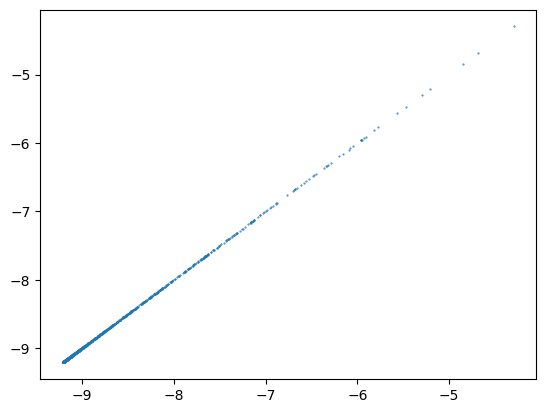

In [94]:
plt.scatter( lncounts.mean(0).cpu().detach(), decoder_centers.cpu().detach(), s=.2 )

In [156]:
import torch

dim1 = 200

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2000, dim1),
            nn.BatchNorm1d(dim1),
            nn.ReLU(),
            nn.Linear(dim1, 20),
            nn.BatchNorm1d(20),
            #nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, dim1),
            nn.BatchNorm1d(dim1),
            nn.ReLU(),
            nn.Linear(dim1, 2000),
            #nn.BatchNorm1d(2000),
            #nn.ReLU()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder().cuda()

counts = torch.tensor( ad.layers["counts"].todense(), dtype=torch.float32 ).cuda()
totals = counts.sum(1)
lncounts = torch.log(counts / totals[:, None] + 1e-4)
gene_means = lncounts.mean(0).detach()

eta_hat = model( lncounts - gene_means )
lambda_hat = torch.exp( eta_hat + gene_means ) * totals[:,None]

alpha = .1**2
nbprob = 1. / (lambda_hat * alpha + 1)
nbprob = torch.clamp( nbprob, 1e-5, 1-1e-5 )
log_likelihood_part = torch.xlogy(counts, 1 - nbprob) + torch.xlogy(1. / alpha, nbprob)
loss = -log_likelihood_part.sum()
loss

tensor(1.1175e+08, device='cuda:0', grad_fn=<NegBackward0>)

In [ ]:
model = Autoencoder().cuda()

optimizer = torch.optim.Adam( model.parameters(), lr=1e-4, eps=1e-3 )
num_epochs = 10000

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    eta_hat = model( lncounts - gene_means )
    lambda_hat = torch.exp( eta_hat + gene_means ) * totals[:,None]
    
    # Compute negative binomial loss
    alpha = .1**2
    nbprob = 1. / (lambda_hat * alpha + 1)
    nbprob = torch.clamp( nbprob, 1e-5, 1-1e-5 )
    log_likelihood_part = torch.xlogy(counts, 1 - nbprob) + torch.xlogy(1. / alpha, nbprob)
    #loss = -log_likelihood_part.sum()

    ncells = log_likelihood_part.shape[0]
    indices = torch.randperm(ncells)[:int(ncells * 0.5)]
    loss = -log_likelihood_part[indices,:].sum()

    if torch.isnan(loss).item():
        print( "loss is nan" )
        break
    
    # Backward pass and optimization
    prev_model = copy.deepcopy(model)
    loss.backward()
    optimizer.step()

    # Print loss for every epoch
    if epoch % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

        with torch.no_grad():
            log_likelihood = torch.lgamma( counts + 1./alpha ) - math.lgamma(1./alpha) - torch.lgamma( counts + 1 ) + \
                torch.xlogy( counts, 1 - nbprob ) + torch.xlogy( 1./alpha, nbprob )
            nbprob0 = 1. / ( counts * alpha + 1 )
            log_likelihood_saturated = torch.lgamma( counts + 1./alpha ) - math.lgamma(1./alpha) - torch.lgamma( counts + 1 ) + \
                torch.xlogy( counts, 1 - nbprob0 ) + torch.xlogy( 1./alpha, nbprob0 )
            deviance = -2* (log_likelihood - log_likelihood_saturated )
            print( ( deviance.mean().item(), deviance.median().item() ) )


Epoch [1/10000], Loss: 55641060.0000
(2.377359628677368, 0.27460822463035583)
Epoch [101/10000], Loss: 45340408.0000
(1.212778925895691, 0.15660692751407623)
Epoch [201/10000], Loss: 41378816.0000
(0.7834348082542419, 0.106899693608284)
Epoch [301/10000], Loss: 39834776.0000
(0.6122679710388184, 0.08111453056335449)
Epoch [401/10000], Loss: 39382276.0000
(0.5320304036140442, 0.06471727043390274)
Epoch [501/10000], Loss: 38694312.0000
(0.4885430932044983, 0.05359175428748131)
Epoch [601/10000], Loss: 38619464.0000
(0.4614768624305725, 0.04572198912501335)
Epoch [701/10000], Loss: 38225920.0000
(0.4425472915172577, 0.04007025435566902)
Epoch [801/10000], Loss: 38140004.0000
(0.42818889021873474, 0.03577790781855583)
Epoch [901/10000], Loss: 38014160.0000
(0.4166598916053772, 0.03245140239596367)
Epoch [1001/10000], Loss: 38198444.0000
(0.4070424437522888, 0.029804542660713196)
Epoch [1101/10000], Loss: 38003936.0000
(0.3988170623779297, 0.0276107769459486)
Epoch [1201/10000], Loss: 38060

In [22]:
dfl = deviance.cpu().numpy().flatten()
dfl.sort()
dfl

array([-1.5258789e-05, -1.5258789e-05, -1.5258789e-05, ...,
        4.7333188e+02,  5.7289001e+02,  6.2203540e+02], dtype=float32)

In [12]:
model = Autoencoder().cuda()

alpha = .1**2

optimizer = torch.optim.Adam( model.parameters(), lr=1e-2 )
num_epochs = 10000

# Create DataLoader
dataset = torch.utils.data.TensorDataset( lncounts, counts )
dataloader = torch.utils.data.DataLoader( dataset, batch_size=64, shuffle=True )

# Training loop
for epoch in range(num_epochs):
    model.train()

    epoch_loss = 0
    for batch_lncounts, batch_counts in dataloader:
        optimizer.zero_grad()
    
        # Forward pass
        eta_hat = model( batch_lncounts - gene_means )
        lambda_hat = torch.exp( eta_hat + gene_means ) * batch_counts.sum(1)[:,None]
    
        # Compute negative binomial loss
        nbprob = 1. / (lambda_hat * alpha + 1)
        log_likelihood_part = torch.xlogy( batch_counts, 1 - nbprob ) + torch.xlogy( 1. / alpha, nbprob )
        loss = -log_likelihood_part.sum()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Print loss
    if epoch % 50 == 0:
        model.eval()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

        with torch.no_grad():
            eta_hat = model( lncounts - gene_means )
            lambda_hat = torch.exp( eta_hat + gene_means ) * counts.sum(1)[:,None]
    
            nbprob = 1. / (lambda_hat * alpha + 1)
            log_likelihood = torch.lgamma( counts + 1./alpha ) - math.lgamma(1./alpha) - torch.lgamma( counts + 1 ) + \
                torch.xlogy( counts, 1 - nbprob ) + torch.xlogy( 1./alpha, nbprob )
            nbprob0 = 1. / ( counts * alpha + 1 )
            log_likelihood_saturated = torch.lgamma( counts + 1./alpha ) - math.lgamma(1./alpha) - torch.lgamma( counts + 1 ) + \
                torch.xlogy( counts, 1 - nbprob0 ) + torch.xlogy( 1./alpha, nbprob0 )
            deviance = -2* (log_likelihood - log_likelihood_saturated )
            print( ( deviance.mean().item(), deviance.median().item() ) )


Epoch [1/10000], Loss: nan
(nan, nan)


KeyboardInterrupt: 

In [559]:
batch_counts.sum(1).shape

torch.Size([64])